# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

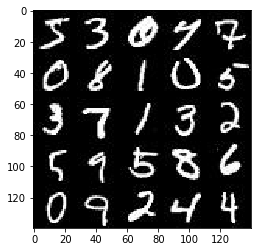

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

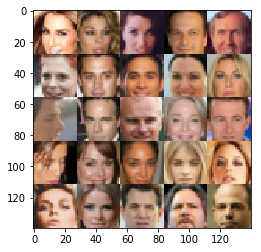

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\ProgramData\\Anaconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\ProgramData\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", li

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28 X 28 X ?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # 14 X 14 X 64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        relu2 = tf.maximum(alpha*x2, x2)
        # 7x7x128
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha*x1, x1)
        # 7 x 7 x 256 now
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*x2, x2)
        # 14 x 14 x 128 now
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x output_dim now
        out = 0.5 * tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # add smooth factor 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate_, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_channels = 3 if data_image_mode is 'RGB' else 1
    (inputs_real, inputs_z, learning_rate) = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_count = 0
            for batch_images in get_batches(batch_size):
                # Generate batch-size of random z vector
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z:batch_z, learning_rate:learning_rate_})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, learning_rate: learning_rate_})
                
                if batch_count % 100 ==0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print('Epoch: {}'.format(epoch_i),
                         'Generator Loss: {}'.format(train_loss_g),
                         'Discriminator Loss: {}'.format(train_loss_d))
                batch_count += 1
            show_generator_output(sess, 4, inputs_z, image_channels, data_image_mode)
            #saver.save(sess, './checkpoints/gan')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 Generator Loss: 0.570073664188385 Discriminator Loss: 1.3671966791152954
Epoch: 0 Generator Loss: 0.49201953411102295 Discriminator Loss: 1.5362169742584229
Epoch: 0 Generator Loss: 0.8024917840957642 Discriminator Loss: 1.3365474939346313
Epoch: 0 Generator Loss: 0.745074987411499 Discriminator Loss: 1.3433294296264648
Epoch: 0 Generator Loss: 0.9458140730857849 Discriminator Loss: 1.1668932437896729


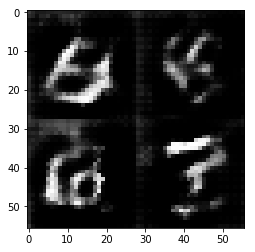

Epoch: 1 Generator Loss: 0.818061888217926 Discriminator Loss: 1.3001635074615479
Epoch: 1 Generator Loss: 1.1742388010025024 Discriminator Loss: 1.1549161672592163
Epoch: 1 Generator Loss: 0.8905400037765503 Discriminator Loss: 1.1827335357666016
Epoch: 1 Generator Loss: 0.9716829061508179 Discriminator Loss: 1.1752190589904785
Epoch: 1 Generator Loss: 0.9800384044647217 Discriminator Loss: 1.1668142080307007


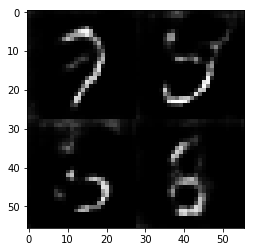

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 Generator Loss: 0.5985003709793091 Discriminator Loss: 1.4094321727752686
Epoch: 0 Generator Loss: 0.8996490240097046 Discriminator Loss: 1.3018527030944824
Epoch: 0 Generator Loss: 0.9400498270988464 Discriminator Loss: 1.2736573219299316
Epoch: 0 Generator Loss: 0.8807709217071533 Discriminator Loss: 1.2509095668792725
Epoch: 0 Generator Loss: 0.8608913421630859 Discriminator Loss: 1.3001015186309814
Epoch: 0 Generator Loss: 0.8398852348327637 Discriminator Loss: 1.3430156707763672
Epoch: 0 Generator Loss: 0.8974767923355103 Discriminator Loss: 1.3483892679214478
Epoch: 0 Generator Loss: 0.5959859490394592 Discriminator Loss: 1.391891360282898
Epoch: 0 Generator Loss: 0.7918597459793091 Discriminator Loss: 1.3927463293075562
Epoch: 0 Generator Loss: 0.7357243895530701 Discriminator Loss: 1.354965329170227
Epoch: 0 Generator Loss: 0.8265472650527954 Discriminator Loss: 1.3628637790679932
Epoch: 0 Generator Loss: 0.879529595375061 Discriminator Loss: 1.3636724948883057
Epoch: 

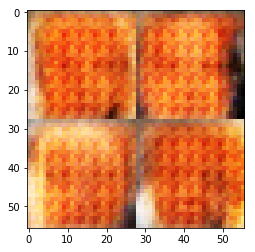

Epoch: 1 Generator Loss: 0.8261014819145203 Discriminator Loss: 1.4283967018127441
Epoch: 1 Generator Loss: 0.8313400745391846 Discriminator Loss: 1.383232593536377
Epoch: 1 Generator Loss: 0.7420264482498169 Discriminator Loss: 1.3692114353179932
Epoch: 1 Generator Loss: 0.7871608734130859 Discriminator Loss: 1.3557188510894775
Epoch: 1 Generator Loss: 0.8803387880325317 Discriminator Loss: 1.4195693731307983
Epoch: 1 Generator Loss: 0.8337389230728149 Discriminator Loss: 1.342677116394043
Epoch: 1 Generator Loss: 0.716843843460083 Discriminator Loss: 1.4009429216384888
Epoch: 1 Generator Loss: 0.7999236583709717 Discriminator Loss: 1.385725498199463
Epoch: 1 Generator Loss: 0.7331768274307251 Discriminator Loss: 1.420460820198059
Epoch: 1 Generator Loss: 0.8083608150482178 Discriminator Loss: 1.365845799446106
Epoch: 1 Generator Loss: 0.8238189816474915 Discriminator Loss: 1.4192932844161987
Epoch: 1 Generator Loss: 0.8011420965194702 Discriminator Loss: 1.4104907512664795
Epoch: 1 G

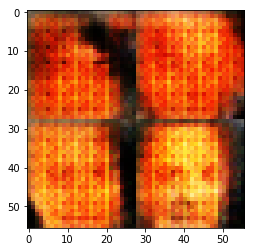

Epoch: 2 Generator Loss: 0.7604390382766724 Discriminator Loss: 1.4076294898986816
Epoch: 2 Generator Loss: 0.7854737639427185 Discriminator Loss: 1.3262603282928467
Epoch: 2 Generator Loss: 0.7840182781219482 Discriminator Loss: 1.3707382678985596
Epoch: 2 Generator Loss: 0.7383406758308411 Discriminator Loss: 1.382439136505127
Epoch: 2 Generator Loss: 0.784449577331543 Discriminator Loss: 1.3403291702270508
Epoch: 2 Generator Loss: 0.8053255677223206 Discriminator Loss: 1.3461034297943115
Epoch: 2 Generator Loss: 0.9158978462219238 Discriminator Loss: 1.4272863864898682
Epoch: 2 Generator Loss: 0.8448643088340759 Discriminator Loss: 1.3473305702209473
Epoch: 2 Generator Loss: 0.7891316413879395 Discriminator Loss: 1.3846733570098877
Epoch: 2 Generator Loss: 0.7852482199668884 Discriminator Loss: 1.3254034519195557
Epoch: 2 Generator Loss: 0.9886512756347656 Discriminator Loss: 1.377211332321167
Epoch: 2 Generator Loss: 0.7314768433570862 Discriminator Loss: 1.3787708282470703
Epoch: 

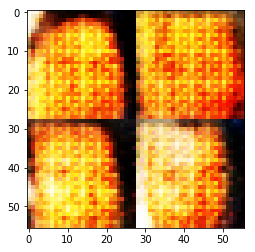

Epoch: 3 Generator Loss: 0.8566141128540039 Discriminator Loss: 1.344990849494934
Epoch: 3 Generator Loss: 0.8249999284744263 Discriminator Loss: 1.352694034576416
Epoch: 3 Generator Loss: 0.811067521572113 Discriminator Loss: 1.3494356870651245
Epoch: 3 Generator Loss: 0.7447264194488525 Discriminator Loss: 1.3804430961608887
Epoch: 3 Generator Loss: 0.8356702327728271 Discriminator Loss: 1.3618748188018799
Epoch: 3 Generator Loss: 0.9029255509376526 Discriminator Loss: 1.368477702140808
Epoch: 3 Generator Loss: 0.791306734085083 Discriminator Loss: 1.3463432788848877
Epoch: 3 Generator Loss: 0.764358401298523 Discriminator Loss: 1.3728690147399902
Epoch: 3 Generator Loss: 0.7024394273757935 Discriminator Loss: 1.3835958242416382
Epoch: 3 Generator Loss: 0.8691590428352356 Discriminator Loss: 1.3504879474639893
Epoch: 3 Generator Loss: 1.0787023305892944 Discriminator Loss: 1.3795918226242065
Epoch: 3 Generator Loss: 0.8105174899101257 Discriminator Loss: 1.3205583095550537
Epoch: 3 G

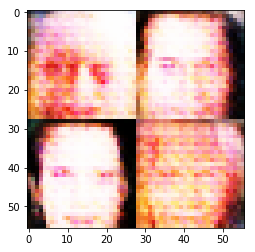

Epoch: 4 Generator Loss: 0.8181790709495544 Discriminator Loss: 1.3976192474365234
Epoch: 4 Generator Loss: 0.7506835460662842 Discriminator Loss: 1.4291565418243408
Epoch: 4 Generator Loss: 0.6898059844970703 Discriminator Loss: 1.367607831954956
Epoch: 4 Generator Loss: 0.6691550016403198 Discriminator Loss: 1.388408899307251
Epoch: 4 Generator Loss: 0.8557438254356384 Discriminator Loss: 1.3267440795898438
Epoch: 4 Generator Loss: 0.7597829103469849 Discriminator Loss: 1.3734155893325806
Epoch: 4 Generator Loss: 0.801742434501648 Discriminator Loss: 1.3473799228668213
Epoch: 4 Generator Loss: 0.8187094926834106 Discriminator Loss: 1.3559012413024902
Epoch: 4 Generator Loss: 0.8176108598709106 Discriminator Loss: 1.374054193496704
Epoch: 4 Generator Loss: 0.8028532862663269 Discriminator Loss: 1.3702822923660278
Epoch: 4 Generator Loss: 0.9335358142852783 Discriminator Loss: 1.324751615524292
Epoch: 4 Generator Loss: 0.8128988742828369 Discriminator Loss: 1.3628202676773071
Epoch: 4 

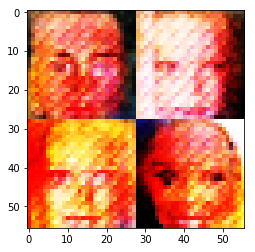

Epoch: 5 Generator Loss: 0.8425065279006958 Discriminator Loss: 1.307342529296875
Epoch: 5 Generator Loss: 0.8300740718841553 Discriminator Loss: 1.367664098739624
Epoch: 5 Generator Loss: 0.8034895658493042 Discriminator Loss: 1.3466788530349731
Epoch: 5 Generator Loss: 0.6952553987503052 Discriminator Loss: 1.3674999475479126
Epoch: 5 Generator Loss: 0.7813364267349243 Discriminator Loss: 1.354831337928772
Epoch: 5 Generator Loss: 0.8018639087677002 Discriminator Loss: 1.3628919124603271
Epoch: 5 Generator Loss: 0.8045623898506165 Discriminator Loss: 1.3505680561065674
Epoch: 5 Generator Loss: 0.7924146056175232 Discriminator Loss: 1.366926908493042
Epoch: 5 Generator Loss: 0.7142013311386108 Discriminator Loss: 1.3842164278030396
Epoch: 5 Generator Loss: 0.744268536567688 Discriminator Loss: 1.344101905822754
Epoch: 5 Generator Loss: 0.8633517622947693 Discriminator Loss: 1.3547194004058838
Epoch: 5 Generator Loss: 0.7956389784812927 Discriminator Loss: 1.3763173818588257
Epoch: 5 G

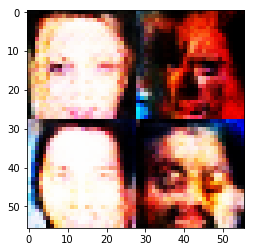

Epoch: 6 Generator Loss: 0.7982102036476135 Discriminator Loss: 1.341589331626892
Epoch: 6 Generator Loss: 0.7837620973587036 Discriminator Loss: 1.361746907234192
Epoch: 6 Generator Loss: 0.9152086973190308 Discriminator Loss: 1.39003324508667
Epoch: 6 Generator Loss: 0.6795415878295898 Discriminator Loss: 1.390793800354004
Epoch: 6 Generator Loss: 0.8365819454193115 Discriminator Loss: 1.3406457901000977
Epoch: 6 Generator Loss: 0.7379945516586304 Discriminator Loss: 1.3514244556427002
Epoch: 6 Generator Loss: 0.8544814586639404 Discriminator Loss: 1.341263771057129
Epoch: 6 Generator Loss: 0.8105673789978027 Discriminator Loss: 1.3069674968719482
Epoch: 6 Generator Loss: 0.8345564603805542 Discriminator Loss: 1.3617799282073975
Epoch: 6 Generator Loss: 0.8105539083480835 Discriminator Loss: 1.3588964939117432
Epoch: 6 Generator Loss: 0.9048553109169006 Discriminator Loss: 1.3652257919311523
Epoch: 6 Generator Loss: 0.8869162797927856 Discriminator Loss: 1.3839200735092163
Epoch: 6 G

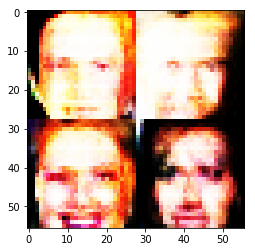

Epoch: 7 Generator Loss: 0.7215569615364075 Discriminator Loss: 1.3849151134490967
Epoch: 7 Generator Loss: 0.7502915859222412 Discriminator Loss: 1.3548130989074707
Epoch: 7 Generator Loss: 0.6672648191452026 Discriminator Loss: 1.3903288841247559
Epoch: 7 Generator Loss: 0.6911703944206238 Discriminator Loss: 1.3831532001495361
Epoch: 7 Generator Loss: 0.777026891708374 Discriminator Loss: 1.3583625555038452
Epoch: 7 Generator Loss: 0.7914719581604004 Discriminator Loss: 1.3184051513671875
Epoch: 7 Generator Loss: 0.7756063938140869 Discriminator Loss: 1.3735177516937256
Epoch: 7 Generator Loss: 0.7778960466384888 Discriminator Loss: 1.3529105186462402
Epoch: 7 Generator Loss: 0.8507827520370483 Discriminator Loss: 1.3733930587768555
Epoch: 7 Generator Loss: 0.6853923797607422 Discriminator Loss: 1.4071705341339111
Epoch: 7 Generator Loss: 0.8087484836578369 Discriminator Loss: 1.3959859609603882
Epoch: 7 Generator Loss: 0.9937299489974976 Discriminator Loss: 1.3916715383529663
Epoch

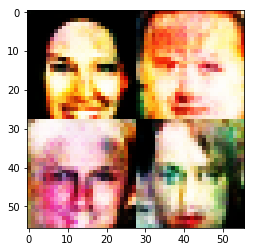

Epoch: 8 Generator Loss: 0.8324146270751953 Discriminator Loss: 1.3634998798370361
Epoch: 8 Generator Loss: 0.8185741901397705 Discriminator Loss: 1.3634672164916992
Epoch: 8 Generator Loss: 0.7557386159896851 Discriminator Loss: 1.353159785270691
Epoch: 8 Generator Loss: 1.049328327178955 Discriminator Loss: 1.4732229709625244
Epoch: 8 Generator Loss: 0.8724942207336426 Discriminator Loss: 1.3333443403244019
Epoch: 8 Generator Loss: 0.8471753597259521 Discriminator Loss: 1.3729166984558105
Epoch: 8 Generator Loss: 0.7750985622406006 Discriminator Loss: 1.3644131422042847
Epoch: 8 Generator Loss: 0.8101345300674438 Discriminator Loss: 1.348305344581604
Epoch: 8 Generator Loss: 0.789320170879364 Discriminator Loss: 1.3575074672698975
Epoch: 8 Generator Loss: 0.7559654712677002 Discriminator Loss: 1.3596606254577637
Epoch: 8 Generator Loss: 0.8567090630531311 Discriminator Loss: 1.3542070388793945
Epoch: 8 Generator Loss: 0.8073260188102722 Discriminator Loss: 1.4059395790100098
Epoch: 8

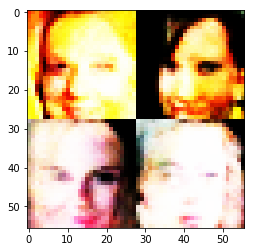

Epoch: 9 Generator Loss: 0.8089288473129272 Discriminator Loss: 1.375802755355835
Epoch: 9 Generator Loss: 0.8559557795524597 Discriminator Loss: 1.3440043926239014
Epoch: 9 Generator Loss: 0.8216272592544556 Discriminator Loss: 1.3404769897460938
Epoch: 9 Generator Loss: 0.7177374362945557 Discriminator Loss: 1.3902623653411865
Epoch: 9 Generator Loss: 0.7928768396377563 Discriminator Loss: 1.3898842334747314
Epoch: 9 Generator Loss: 0.8038004040718079 Discriminator Loss: 1.3531708717346191
Epoch: 9 Generator Loss: 0.7684745788574219 Discriminator Loss: 1.3625710010528564
Epoch: 9 Generator Loss: 0.7667685747146606 Discriminator Loss: 1.3600952625274658
Epoch: 9 Generator Loss: 0.8523060083389282 Discriminator Loss: 1.3484704494476318
Epoch: 9 Generator Loss: 0.6621780395507812 Discriminator Loss: 1.3739774227142334
Epoch: 9 Generator Loss: 0.8871507048606873 Discriminator Loss: 1.3670125007629395
Epoch: 9 Generator Loss: 0.8415614366531372 Discriminator Loss: 1.3726085424423218
Epoch

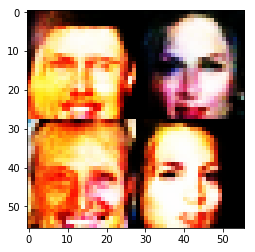

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.